In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH = "../Data/Miles_Traveled.csv"

df = pd.read_csv(PATH, index_col='DATE', parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.columns = ['Miles']

In [4]:
df.head()

,Miles
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


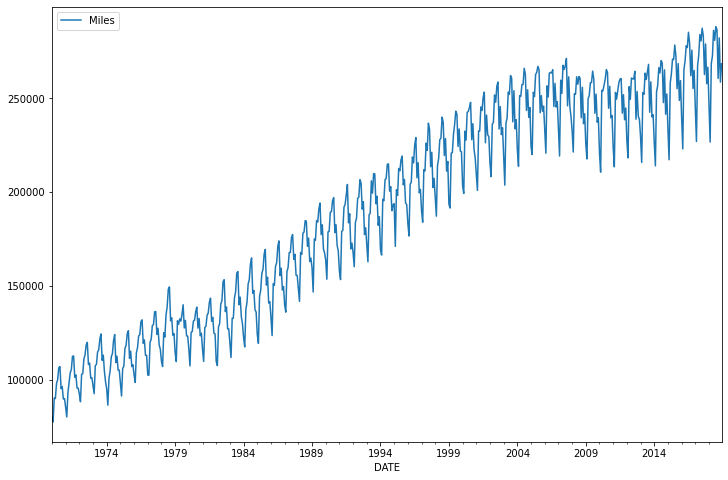

In [5]:
df.plot(figsize=(12,8))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/nathzi1505/Desktop/Private/Online-Courses/Time-Series/Course_Notebooks/venv/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


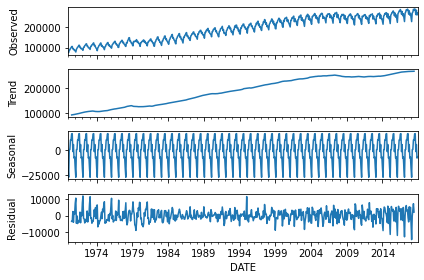

In [7]:
results = seasonal_decompose(df['Miles'])
results.plot();

In [8]:
len(df)

588

In [9]:
# Train Test Split

train = df.iloc[:576]
test = df.iloc[576:]

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [12]:
n_input = 12 # Depends on the seasonality
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input,
                                batch_size=1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [14]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features))) # Start from 100
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit_generator(train_generator, epochs=25)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
564/564 [==============================] - 3s 6ms/step - loss: 0.0092
Epoch 2/25
564/564 [==============================] - 4s 7ms/step - loss: 0.0053
Epoch 3/25
564/564 [==============================] - 5s 9ms/step - loss: 0.0045
Epoch 4/25
564/564 [==============================] - 5s 10ms/step - loss: 0.0024
Epoch 5/25
564/564 [==============================] - 5s 8ms/step - loss: 0.0017
Epoch 6/25
564/564 [==============================] - 5s 8ms/step - loss: 0.0017
Epoch 7/25
564/564 [==============================] - 5s 8ms/step - loss: 0.0016
Epoch 8/25
564/564 [==============================] - 5s 9ms/step - loss: 0.0012
Epoch 9/25
564/564 [==============================] - 4s 7ms/step - loss: 0.0011
Epoch 10/25
564/564 [==============================] - 4s 8ms/step - loss: 0.0010
Epoch 11/25
564/564 [==============================] - 4s 7ms/step - loss: 7.9511e-04
Epoch 12/25
564/564 [=====

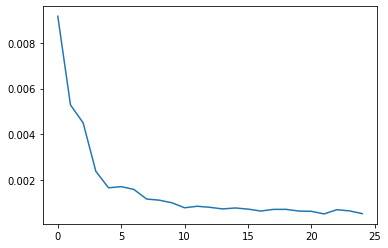

In [17]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [18]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis=1)
    

In [19]:
true_predictions = scaler.inverse_transform(test_predictions)

In [20]:
test['Predictions'] = true_predictions

/Users/nathzi1505/Desktop/Private/Online-Courses/Time-Series/Course_Notebooks/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


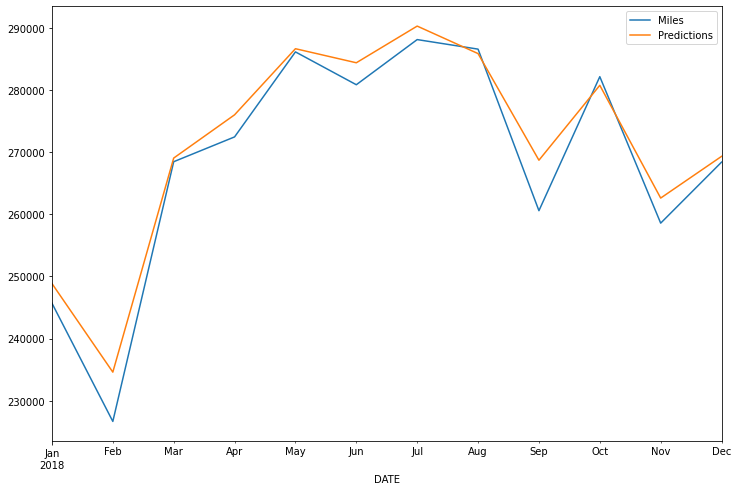

In [21]:
test.plot(figsize=(12,8), legend=True)

In [22]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(test['Miles'], test['Predictions']))

3970.7826333937855

In [23]:
test['Miles'].mean()

268739.6666666667

In [24]:
model.save('dl2.h5')